## Настройки ClickHouse

In [1]:
import utils
import pandas as pd
from utils import simple_ch_client


CH_HOST_NAME = 'rc1c-dp4f585c5tk96k9m.mdb.yandexcloud.net'
CH_USER      = 'firstsvet02'
CH_DB_NAME   = 'AppMetrica_workshop'

#-------------------------------------------
CH_PASS      = open('chpass.txt').read().strip()
CH_HOST      = f'https://{CH_HOST_NAME}:8443'
CH_CASERT    = 'certificate/YandexInternalRootCA.crt'

In [2]:
my_client = simple_ch_client(CH_HOST, CH_USER, CH_PASS, CH_CASERT)

## Агрегируем данные в последовательность пользовательских визитов

In [3]:
import pandas as pd
import requests
import json

In [20]:
q = f'''
SELECT
    appmetrica_device_id,
    num_steps,
    arrayStringConcat(filt_events, ' -> ') as events_seq
FROM
    (SELECT
        appmetrica_device_id,
        groupArray(event_name) as events,
        count(event_name) as cnt_events,
        groupArray(datetime) as times,
        arrayEnumerate(events) as indexes,
        arrayDifference(arrayMap(x -> toUInt64(x), times)) as times_diffs,
        arrayFilter(e, i -> (i = 1) or (events[i - 1] != events[i]) or (times_diffs[i] >= 1800),
                    events, indexes) as filt_events,
        length(filt_events) as num_steps
    FROM 
        (SELECT
            appmetrica_device_id,
            datetime,
            event_name
        FROM {CH_DB_NAME}.raw_appmetrica_auto_data
        ORDER BY appmetrica_device_id,
            datetime)
    GROUP BY appmetrica_device_id
    HAVING cnt_events <= 30)
format TSVWithNames
'''

stat_df = my_client.get_clickhouse_df(q)

In [21]:
stat_df.head()

,appmetrica_device_id,num_steps,events_seq
0,4388665923296595968,7,Поиск по легковым. Выдача -> Выдача. Просмотр ...
1,8512777489338945536,6,Просмотр объявления -> Поиск по легковым. Выда...
2,18303666263673319424,26,Просмотр объявления -> Просмотр объявления -> ...
3,13687251828939507712,7,Просмотр объявления -> Поиск по легковым. Выда...
4,2160844975541044736,1,Выдача. Просмотр сниппета


#### Посмотрим на распределение событий

array([[<AxesSubplot:title={'center':'num_steps'}>]], dtype=object)

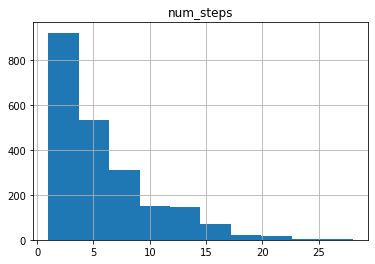

In [22]:
stat_df[['num_steps']].hist()

In [25]:
q = f'drop table if exists {CH_DB_NAME}.user_events_sequence'
my_client.get_clickhouse_data(q)

q = f'''
create table {CH_DB_NAME}.user_events_sequence (
    appmetrica_device_id UInt64,
    num_steps UInt32,
    events_seq String
) ENGINE = MergeTree()
ORDER BY appmetrica_device_id'''

my_client.get_clickhouse_data(q)

''

In [26]:
my_client.upload(
    f'{CH_DB_NAME}.user_events_sequence',
    stat_df.to_csv(index = False, sep = '\t'))

''